# Backtesting Framework. 

In [1]:
# Python module. 
import re, os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import yfinance as yf 
import pyfolio as pf 
import backtrader as bt 
from time import time 

# Change the current directory from (./notebook) to root directory. 
while not re.match(r".+MADS-CAP$", os.getcwd()): 
	os.chdir("..") 
	
print(f"Current directory: ({os.getcwd()})") 

# For clearing safe warnings. Not important. 
from IPython.display import clear_output

# Custom modules. 
from source.modules import visualizer 
from source.modules.manage_files import ManageFiles 
from source.modules.backtesting import (
	format_time, FixedCommisionScheme, SignalData, 
	MLStrategy, RuleBasedStrategy, 
) 

# Custom configs. 
from source.config_py.config import (
	DIR_DATASET, DIR_DATASET_CONSOLIDATED, DIR_DATASET_UTIL, 
	TICKER_TO_COLLECT, TICKER_TO_EXCLUDE, TICKER_DATE_COLLECT, 
	PARAM_SEED, 
)

Current directory: (/Users/lioneltay/Dropbox/Courses/michigan_mads/SIADS_697_/submission/MADS-CAP)


/Users/lioneltay/.local/share/virtualenvs/MADS-CAP-gLyVeGLS/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configurations (general). 

In [2]:
# Matplotlib setting. 
%matplotlib inline 

# Pandas DF config. 
pd.set_option("display.max_rows", 50, "display.max_columns", 100, "display.max_colwidth", 50)

# File management setup. 
manage_files = ManageFiles() 

# List of ticker to collect data. 
ticker_to_collect = TICKER_TO_COLLECT.difference(TICKER_TO_EXCLUDE) 

# # Uncomment this part to use Jeremy's stock pick. 
ticker_to_collect = set(manage_files.load_cache_pk(DIR_DATASET_UTIL, "jeremy_tickers_v1.pickle")) 
ticker_to_collect = ticker_to_collect.difference(TICKER_TO_EXCLUDE) 

# # Uncomment this to specify specific tickers here. 
# ticker_to_collect = set(["AAPL", "AMZN", "MSFT", "JNJ", "LMT", "JPM", "GS"])

# # To compare against which ticker. 
benchmark_tick = "^GSPC"
benchmark_name = "SP500"

# Date range. 
date_beg, date_end = TICKER_DATE_COLLECT 
date_beg = "2000-03-31" 

# For clearing the output. Not important. 
clear_output()

## Load consolidated ticker data. 

### Load dataset. 

In [3]:
filepath = os.path.join(DIR_DATASET_CONSOLIDATED, "consolidated_feature.parquet")
df_feature = pd.read_parquet(filepath) 

# Preview. 
df_feature 

,date,open,high,low,close,volume,dividends,stock_splits,ticker,return_c2c_lag1,tscore_c2c_lag1,return_c2c_lag1_autolag1,tscore_c2c_lag1_autolag1,return_c2c_lag1_autolag2,tscore_c2c_lag1_autolag2,return_c2c_lag1_autolag3,tscore_c2c_lag1_autolag3,vix_date,vix_open,vix_close,date_quarter,vl_ticker,vl_fiscalDateEnding,vl_eps,vl_eps_continuing,vl_rps,vl_date_quarter,vl_pe,vl_pe_continuing,vl_ps,event_jobs_opening_labor_turnover,event_non_farm_employment_adp_mom,event_non_farm_employment_mom,event_unemployment_claims,event_unemployment_rate,event_avg_hourly_earnings_mom,event_personal_dispensable_income_mom,event_personal_consumption_mom,event_ism_pmi_manufacturer,event_ism_pmi_services,event_chicago_pmi,event_industry_production_mom,event_phil_fed_manufacturer,event_capacity_utilisation,event_manufacturer_new_order_mom,event_manufacturer_new_order_ex_trans_mom,event_retail_sales_ex_auto_mom,event_retail_sales_mom,event_uom_consumer_sentiment,event_producer_ppi_mom,...,econ_consumer_sentiment_umich,econ_fed_ffr,econ_mortgage_rate_15yr,econ_mortgage_rate_30yr,econ_prime_loan_rate,rp_ticker,rp_date,rp_relevance,rp_ess,rp_aes,rp_aev,rp_ens,rp_ens_similarity_gap,rp_css,rp_nip,rp_peq,rp_bee,rp_bmq,rp_bam,rp_bca,rp_ber,rp_anl_chg,rp_mcq,techind_ticker,techind_date,techind_macd_MACD,techind_macd_MACD_Hist,techind_macd_MACD_Signal,techind_ema_t20_EMA,techind_ema_t50_EMA,techind_ema_t200_EMA,techind_rsi_t20_RSI,techind_rsi_t50_RSI,candle_cdl3blackcrows,candle_cdldarkcloudcover,candle_cdldoji,candle_cdldojistar,candle_cdldragonflydoji,candle_cdlengulfing,candle_cdleveningdojistar,candle_cdleveningstar,candle_cdlhammer,candle_cdlhangingman,candle_cdlharami,candle_cdlinvertedhammer,candle_cdlmorningdojistar,candle_cdlmorningstar,candle_cdlrickshawman,candle_cdlshootingstar,candle_cdltristar
0,1999-11-23,8.44,8.44,8.44,8.44,60000.0,0.0,0.0,TDY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-11-23,21.07,21.00,1999-12-31,None,NaT,NaN,NaN,NaN,None,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,107.2,5.42,7.36,7.74,8.36,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1999-11-24,8.44,10.69,8.44,10.50,917700.0,0.0,0.0,TDY,0.244076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999-11-24,20.70,20.26,1999-12-31,None,NaT,NaN,NaN,NaN,None,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,107.2,5.42,7.36,7.74,8.36,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1999-11-26,10.50,10.50,10.50,10.50,32700.0,0.0,0.0,TDY,0.000000,NaN,0.244076,NaN,NaN,NaN,NaN,NaN,1999-11-26,20.35,22.33,1999-12-31,None,NaT,NaN,NaN,NaN,None,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,107.2,5.42,7.36,7.74,8.36,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1999-11-29,10.62,10.62,9.25,9.25,511000.0,0.0,0.0,TDY,-0.119048,NaN,0.000000,NaN,0.244076,NaN,NaN,NaN,1999-11-29,24.27,23.57,1999-12-31,None,NaT,NaN,NaN,NaN,None,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,107.2,5.42,7.36,7.74,8.36,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,-100,0,0,0,0,0,0,0,0,0,0,0
4,1999-11-30,9.38,9.38,8.50,8.81,2424000.0,0.0,0.0,TDY,-0.047568,NaN,-0.119048,NaN,0.000000,NaN,0.244076,NaN,1999-11-30,23.81,24.18,1999-12-31,None,NaT,NaN,NaN,NaN,None,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,107.2,5.42,7.36,7.74,8.36,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

### Get specific features & minor processing. 

In [4]:
# Get the specific group of features based on the prefix. 
getcols = [c for c in df_feature.columns if re.match(r"^vl_.+", c)] \
	+ [c for c in df_feature.columns if re.match(r"^techind_.+", c)] \
	+ [c for c in df_feature.columns if re.match(r"^vix_.+", c)] \
	+ [c for c in df_feature.columns if re.match(r"^econ_.+", c)] 

# Preview. 
getcols 

['vl_ticker',
 'vl_fiscalDateEnding',
 'vl_eps',
 'vl_eps_continuing',
 'vl_rps',
 'vl_date_quarter',
 'vl_pe',
 'vl_pe_continuing',
 'vl_ps',
 'techind_ticker',
 'techind_date',
 'techind_macd_MACD',
 'techind_macd_MACD_Hist',
 'techind_macd_MACD_Signal',
 'techind_ema_t20_EMA',
 'techind_ema_t50_EMA',
 'techind_ema_t200_EMA',
 'techind_rsi_t20_RSI',
 'techind_rsi_t50_RSI',
 'vix_date',
 'vix_open',
 'vix_close',
 'econ_date',
 'econ_bond_yield_10yr',
 'econ_bond_yield_10yr_minus_2yr',
 'econ_bond_yield_10yr_minus_3mo',
 'econ_bond_yield_10yr_minus_ffr',
 'econ_bond_yield_2yr',
 'econ_bond_yield_30yr',
 'econ_bond_yield_3mo',
 'econ_bond_yield_5yr',
 'econ_consumer_confidence_oecd',
 'econ_consumer_sentiment_umich',
 'econ_fed_ffr',
 'econ_mortgage_rate_15yr',
 'econ_mortgage_rate_30yr',
 'econ_prime_loan_rate']

In [5]:
# Select the features. 
defcols = [
	"ticker", "date", 
	"open", "high", "low", "volume", "close", 
] 
getcols = [
	"return_c2c_lag1", "tscore_c2c_lag1",
	"vix_close", 
	"vl_pe", "vl_ps",
	"econ_bond_yield_10yr_minus_2yr", 
	"econ_bond_yield_10yr_minus_3mo", 
	"techind_macd_MACD_Hist", "techind_macd_MACD", "techind_macd_MACD_Signal", 
	"techind_ema_t20_EMA", "techind_ema_t50_EMA", "techind_ema_t200_EMA", 
	"techind_rsi_t20_RSI", "techind_rsi_t50_RSI", 
]

# Filter columns. 
df_feature_proc = df_feature.loc[df_feature["ticker"].isin(ticker_to_collect), defcols + getcols] 

# Convert to (datetime) dtype. 
df_feature_proc["date"] = pd.to_datetime(df_feature_proc["date"]) 

# Required by (BackTrader) to rename the date column as (datetime). 
df_feature_proc = df_feature_proc \
	.rename(columns={"date": "datetime"}) \
	.set_index("datetime") \
	.loc[date_beg:date_end, :] 

# Preview. 
df_feature_proc 

,ticker,open,high,low,volume,close,return_c2c_lag1,tscore_c2c_lag1,vix_close,vl_pe,vl_ps,econ_bond_yield_10yr_minus_2yr,econ_bond_yield_10yr_minus_3mo,techind_macd_MACD_Hist,techind_macd_MACD,techind_macd_MACD_Signal,techind_ema_t20_EMA,techind_ema_t50_EMA,techind_ema_t200_EMA,techind_rsi_t20_RSI,techind_rsi_t50_RSI
datetime,,,,,,,,,,,,,,,,,,,,,
2000-03-31,TDY,18.25,19.12,16.50,580600.0,18.50,-0.026316,NaN,24.11,NaN,NaN,-0.47,0.15,0.7214,2.7375,2.0161,14.8101,11.9850,NaN,63.9190,63.3062
2000-04-03,TDY,17.50,17.62,15.50,455200.0,15.81,-0.145405,NaN,24.03,NaN,NaN,-0.45,0.13,0.3623,2.4689,2.1067,14.9054,12.1350,NaN,56.6810,58.1819
2000-04-04,TDY,15.75,15.75,13.38,775200.0,14.88,-0.058824,NaN,27.12,NaN,NaN,-0.45,0.07,0.0396,2.1562,2.1166,14.9030,12.2427,NaN,54.4377,56.5666
2000-04-05,TDY,14.88,16.88,14.38,387000.0,16.00,0.075269,NaN,28.41,NaN,NaN,-0.45,0.04,-0.1126,1.9759,2.0884,15.0074,12.3900,NaN,56.6145,57.9996
2000-04-06,TDY,16.25,16.62,15.12,311000.0,15.81,-0.011875,NaN,27.15,NaN,NaN,-0.45,0.05,-0.2332,1.7970,2.0301,15.0839,12.5241,NaN,56.1355,57.6702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-18,MOS,45.49,45.79,44.42,4823100.0,44.79,-0.022266,-0.952283,27.75,10.576886,1.395693,0.45,1.57,0.0498,1.5046,1.4548,43.7342,41.4175,36.1478,58.2486,57.2518
2022-02-22,MOS,45.50,45.63,43.38,7738900.0,43.99,-0.017861,-0.776731,28.81,10.579211,1.396000,0.38,1.57,-0.0913,1.3406,1.4319,43.7581,41.5182,36.2258,55.5044,56.0585
2022-02-23,MOS,42.59,45.59,42.16,9786700.0,44.99,0.022732,0.842288,31.02,9.902606,1.306717,0.41,1.65,-0.1239,1.2770,1.4009,43.8755,41.6544,36.3130,58.0956,57.1937


### Analyse distribution. 

In [6]:
# # Pick the column name to check the distribution. 
# targcol = "techind_rsi_t20_RSI"
# plt.hist(x=df_feature_proc.loc["2000-01-01":"2018-01-01", targcol], bins=100) 
# plt.xlim(-5,5) 
# plt.title(targcol) 

### Analyse feature over time. 

In [7]:
# df_copy = df_feature_proc.loc["2000-01-01":"2018-01-01", :].reset_index(drop=False).copy()
# visualizer.plot_timeseries(df_copy, x="datetime", y="techind_rsi_t20_RSI", ylim=[30,70], tickers=ticker_to_collect) 

## Backtesting. 

### Assign the signal. 

In [8]:
# Process signal for RSI. 
df_feature_proc["techind_rsi_t20_RSI_signal"] = np.nan  
df_feature_proc.loc[(df_feature_proc["techind_rsi_t20_RSI"] < 30), "techind_rsi_t20_RSI_signal"] = 1 

# Process signal for yield. 
df_feature_proc["econ_bond_yield_10yr_minus_3mo_thres"] = np.nan 
df_feature_proc.loc[(df_feature_proc["econ_bond_yield_10yr_minus_3mo"] < 0), "econ_bond_yield_10yr_minus_3mo_thres"] = 1 

for ticker in ticker_to_collect: 
	boo_ticker = df_feature_proc["ticker"] == ticker 

	df_feature_proc.loc[boo_ticker, "techind_rsi_t20_RSI_signal"] = df_feature_proc.loc[boo_ticker, "techind_rsi_t20_RSI_signal"] \
		.ffill(limit=5) \
		.fillna(0) 

	df_feature_proc.loc[boo_ticker, "econ_bond_yield_10yr_minus_3mo_thres"] = df_feature_proc.loc[boo_ticker, "econ_bond_yield_10yr_minus_3mo_thres"] \
		.ffill(limit=252) \
		.fillna(0) 

In [9]:
# --------------------------------------------------
# Set up the rules or conditions for the signal. 
# --------------------------------------------------

boo_macd_hist_bull = (df_feature_proc["techind_macd_MACD_Hist"] > 0) & (df_feature_proc["techind_macd_MACD_Hist"] <  1)
boo_macd_hist_bear = (df_feature_proc["techind_macd_MACD_Hist"] < 0) & (df_feature_proc["techind_macd_MACD_Hist"] > -1)

boo_macd_line_bull = (df_feature_proc["techind_macd_MACD"] > 0.15) 
boo_macd_sign_bull = (df_feature_proc["techind_macd_MACD_Signal"] > 0.15) 

boo_macd_line_bear = (df_feature_proc["techind_macd_MACD"] < -0.15) 
boo_macd_sign_bear = (df_feature_proc["techind_macd_MACD_Signal"] < -0.15) 

boo_rsi_thres_bull = (df_feature_proc["techind_rsi_t20_RSI"] <= 75) 
boo_rsi_thres_bear = (df_feature_proc["techind_rsi_t20_RSI"] >= 30) 

boo_rsi_signal_bull = df_feature_proc["techind_rsi_t20_RSI_signal"] > 0 
boo_rsi_signal_bear = df_feature_proc["techind_rsi_t20_RSI_signal"] < 0 

boo_yield_thres_fine = df_feature_proc["econ_bond_yield_10yr_minus_3mo_thres"] == 0 
boo_yield_thres_halt = df_feature_proc["econ_bond_yield_10yr_minus_3mo_thres"] == 1 

boo_vix_thres_halt = df_feature_proc["vix_close"] >  30 
boo_vix_thres_fine = df_feature_proc["vix_close"] <= 30 

boo_pe = (
	(df_feature_proc["vl_pe"] <= 35) & \
	(df_feature_proc["vl_pe"] > 15)) | \
	(df_feature_proc["vl_pe"].isnull()
) 
boo_pe_halt = df_feature_proc["vl_pe"] > 40 

# --------------------------------------------------
# Combine the conditions. 
# --------------------------------------------------

# Condition for reversal trend. 
boo_condition_longs_rever = (
	boo_rsi_signal_bull 
	& boo_vix_thres_fine 
) 

# Condition for trading the trend. 
boo_condition_longs_trend = (
	boo_macd_hist_bull 
	& boo_macd_line_bull 
	& boo_macd_sign_bull 
	& boo_rsi_thres_bull 
	& boo_vix_thres_fine 
) 

boo_condition_short_trend = (
	boo_macd_hist_bear 
	& boo_macd_line_bear 
	& boo_macd_sign_bear 
) 

# Condition for exiting a long term investment. 
boo_condition_invest_halt = (
	boo_yield_thres_halt 
) 

# --------------------------------------------------
# Create signal. 
# --------------------------------------------------

# # Create the signal for (RuleBased) model. The trade 
# # will be executed on the next day at opening price. 

df_feature_proc["signal"] = 0 
df_feature_proc.loc[boo_condition_longs_trend, "signal"] = 1 
 
# df_feature_proc["signal"] = 1 
# df_feature_proc.loc[boo_condition_invest_halt, "signal"] = 0 

# Preview. 
df_feature_proc 

,ticker,open,high,low,volume,close,return_c2c_lag1,tscore_c2c_lag1,vix_close,vl_pe,vl_ps,econ_bond_yield_10yr_minus_2yr,econ_bond_yield_10yr_minus_3mo,techind_macd_MACD_Hist,techind_macd_MACD,techind_macd_MACD_Signal,techind_ema_t20_EMA,techind_ema_t50_EMA,techind_ema_t200_EMA,techind_rsi_t20_RSI,techind_rsi_t50_RSI,techind_rsi_t20_RSI_signal,econ_bond_yield_10yr_minus_3mo_thres,signal
datetime,,,,,,,,,,,,,,,,,,,,,,,,
2000-03-31,TDY,18.25,19.12,16.50,580600.0,18.50,-0.026316,NaN,24.11,NaN,NaN,-0.47,0.15,0.7214,2.7375,2.0161,14.8101,11.9850,NaN,63.9190,63.3062,0.0,0.0,1
2000-04-03,TDY,17.50,17.62,15.50,455200.0,15.81,-0.145405,NaN,24.03,NaN,NaN,-0.45,0.13,0.3623,2.4689,2.1067,14.9054,12.1350,NaN,56.6810,58.1819,0.0,0.0,1
2000-04-04,TDY,15.75,15.75,13.38,775200.0,14.88,-0.058824,NaN,27.12,NaN,NaN,-0.45,0.07,0.0396,2.1562,2.1166,14.9030,12.2427,NaN,54.4377,56.5666,0.0,0.0,1
2000-04-05,TDY,14.88,16.88,14.38,387000.0,16.00,0.075269,NaN,28.41,NaN,NaN,-0.45,0.04,-0.1126,1.9759,2.0884,15.0074,12.3900,NaN,56.6145,57.9996,0.0,0.0,0
2000-04-06,TDY,16.25,16.62,15.12,311000.0,15.81,-0.011875,NaN,27.15,NaN,NaN,-0.45,0.05,-0.2332,1.7970,2.0301,15.0839,12.5241,NaN,56.1355,57.6702,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-18,MOS,45.49,45.79,44.42,4823100.0,44.79,-0.022266,-0.952283,27.75,10.576886,1.395693,0.45,1.57,0.0498,1.5046,1.4548,43.7342,41.4175,36.1478,58.2486,57.2518,0.0,0.0,1
2022-02-22,MOS,45.50,45.63,43.38,7738900.0,43.99,-0.017861,-0.776731,28.81,10.579211,1.396000,0.38,1.57,-0.0913,1.3406,1.4319,43.7581,41.5182,36.2258,55.5044,56.0585,0.0,0.0,0
2022-02-23,MOS,42.59,45.59,42.16,9786700.0,44.99,0.022732,0.842288,31.02,9.902606,1.306717,0.41,1.65,-0.1239,1.2770,1.4009,43.8755,41.6544,36.3130,58.0956,57.1937,0.0,0.0,0


### Check the signal distribution. 

In [10]:
# Check the signal distribution. 
df_feature_proc["signal"].value_counts(normalize=False) 

0    813352
1    209808
Name: signal, dtype: int64

### Execute the backtesting. 

In [11]:
"""
Cerebro documentation: 
	— https://github.com/mementum/backtrader/blob/e2674b1690f6366e08646d8cfd44af7bb71b3970/backtrader/cerebro.py#L747
	— https://github.com/mementum/backtrader/blob/e2674b1690f6366e08646d8cfd44af7bb71b3970/backtrader/brokers/bbroker.py
	— https://github.com/mementum/backtrader/blob/e2674b1690f6366e08646d8cfd44af7bb71b3970/backtrader/brokers/ibbroker.py
	— https://github.com/mementum/backtrader/blob/e2674b1690f6366e08646d8cfd44af7bb71b3970/backtrader/comminfo.py
    — https://github.com/mementum/backtrader/blob/master/backtrader/analyzers/pyfolio.py
"""

# Initiate a "Cerebro" instance and other parameters. 
cerebro = bt.Cerebro()
cash = 100000
comminfo = FixedCommisionScheme()

# Broker setup. 
cerebro.broker.addcommissioninfo(comminfo)
cerebro.broker.setcash(cash)

# Add multiple ticker data. 
for ticker in ticker_to_collect:
    df_data = df_feature_proc[df_feature_proc["ticker"] == ticker].sort_values("datetime", axis=0)
    bt_data = SignalData(dataname=df_data)
    cerebro.adddata(bt_data, name=ticker)

# You can add multiple analyser. 
cerebro.addanalyzer(bt.analyzers.PyFolio, _name="pyfolio")

# Ensure reproducibility. 
np.random.seed(PARAM_SEED) 

# You can add multiple strategies. 
logpath = os.path.join(DIR_DATASET, "bt_log.csv")
cerebro.addstrategy(
	RuleBasedStrategy, n_positions=2, min_positions=1, 
	include_short=False, topn=-1, verbose=True, log_file=logpath
)

# Execute the backtesting and get the return value of the strategy. 
start = time()
results = cerebro.run()
ending_value = cerebro.broker.getvalue()
duration = time() - start

print(f"Final Portfolio Value: {ending_value:,.2f}")
print(f"Duration: {format_time(duration)}")

Final Portfolio Value: 113,298.35
Duration: 00:16:04


### Visualise the backtesting result. 

In [12]:
# # Unable to run this unless (Matplotlib) is downgraded to (3.2.2). 
# # (BackTrader) has not been updated for a long while. 

# # Plot the results. Disabled because large number of datafeeds all plot separately.
# cerebro.plot() 
# figure = cerebro.plot(style="candlebars")[0][0]
# figure.savefig(f"backtrader.png")

## Porfolio assessment. 

### Get S&P benchmark. 

In [13]:
df_benchmark = yf \
	.Ticker(benchmark_tick) \
	.history(period="max", interval="1d", start=date_beg, end=date_end, auto_adjust=True, rounding=True) \
	.loc[:, "Close"] \
	.pct_change() \
	.tz_localize("UTC") 

# Preview. 
df_benchmark.name = benchmark_name

# Preview. 
df_benchmark 

Date
2000-03-30 00:00:00+00:00         NaN
2000-03-31 00:00:00+00:00    0.007164
2000-04-03 00:00:00+00:00    0.004931
2000-04-04 00:00:00+00:00   -0.007464
2000-04-05 00:00:00+00:00   -0.004924
                               ...   
2022-02-18 00:00:00+00:00   -0.007166
2022-02-22 00:00:00+00:00   -0.010143
2022-02-23 00:00:00+00:00   -0.018412
2022-02-24 00:00:00+00:00    0.014957
2022-02-25 00:00:00+00:00    0.022373
Name: SP500, Length: 5513, dtype: float64

### Get the transactions. 

In [14]:
# Prepare (pyfolio) inputs. 
pyfolio_analyzer = results[0].analyzers.getbyname("pyfolio")
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items() 

# Get the transaction for longs and short. 
df_transactions = transactions.groupby(level=0)
df_longs = df_transactions.value.apply(lambda x: x.where(x > 0).sum())
df_short = df_transactions.value.apply(lambda x: x.where(x < 0).sum())

### Visualise the result. 

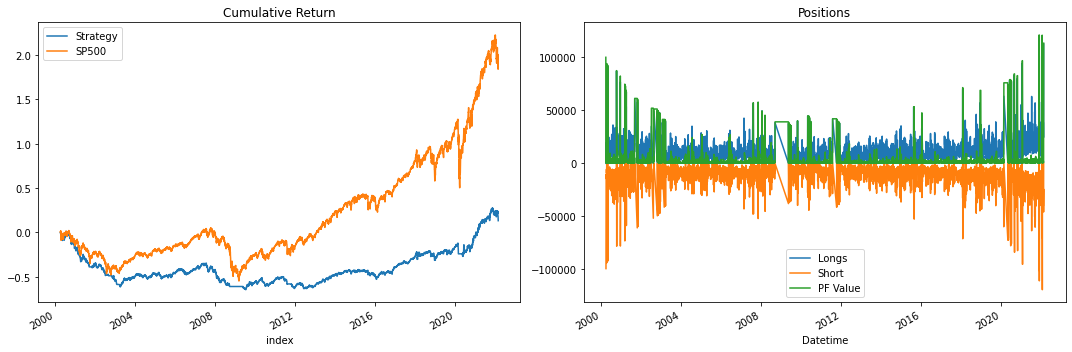

In [15]:
%matplotlib inline 

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

# Merge by date index. 
df_compare_benchmark = returns.to_frame("Strategy").join(df_benchmark.to_frame(benchmark_name))

# Compute the cumulative return. 
df_compare_benchmark.add(1).cumprod().sub(1).plot(ax=axes[0], title="Cumulative Return")

# Plot. 
df_longs.plot(label="Longs", ax=axes[1], title="Positions")
df_short.plot(label="Short", ax=axes[1], title="Positions")
positions.cash.plot(label="PF Value", ax=axes[1])
axes[1].legend()

fig.tight_layout()

/Users/lioneltay/.local/share/virtualenvs/MADS-CAP-gLyVeGLS/lib/python3.8/site-packages/pyfolio/utils.py:316: UserWarning: Detected intraday strategy; inferring positions from transactions. Set estimate_intraday=False to disable.
  warnings.warn(


Start date,2000-03-31
End date,2022-02-25
Total months,262
,Backtest
Annual return,0.572%
Cumulative returns,13.298%
Annual volatility,14.704%
Sharpe ratio,0.11
Calmar ratio,0.01
Stability,0.14
Max drawdown,-64.923%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,64.92,2000-07-11,2009-07-08,2021-02-16,5376
1,11.15,2021-11-15,2022-02-24,NaT,NaN
2,9.49,2000-04-12,2000-05-10,2000-07-11,65
3,4.25,2021-09-02,2021-09-21,2021-09-24,17
4,3.57,2021-05-17,2021-06-18,2021-07-01,34


Stress Events,mean,min,max
Dotcom,-0.01%,-5.46%,3.39%
Lehman,-0.11%,-4.58%,4.95%
9/11,0.00%,0.00%,0.00%
US downgrade/European Debt Crisis,0.04%,0.00%,0.88%
Fukushima,0.12%,-1.03%,0.97%
US Housing,-0.45%,-2.85%,0.56%
EZB IR Event,-0.07%,-1.38%,1.50%
Aug07,-0.26%,-2.21%,2.35%
Mar08,-0.21%,-3.45%,3.88%
Sept08,-0.22%,-4.58%,4.95%


Top 10 long positions of all time,max
sid,
TRV,690605.41%
SIVB,215315.63%
CF,123600.00%
WBD,97310.55%
HES,69831.13%
CTAS,66993.24%
PRU,57474.35%
NI,51612.18%
NEE,51463.24%


Top 10 short positions of all time,max
sid,
ATVI,-753427.03%
CF,-685463.93%
LYV,-176923.83%
ABC,-171219.53%
CCI,-171031.03%
IT,-170693.36%
BIO,-159025.44%
BDX,-93497.30%
BXP,-91548.65%


Top 10 positions of all time,max
sid,
ATVI,753427.03%
TRV,690605.41%
CF,685463.93%
SIVB,215315.63%
LYV,176923.83%
ABC,171219.53%
CCI,171031.03%
IT,170693.36%
BIO,159025.44%


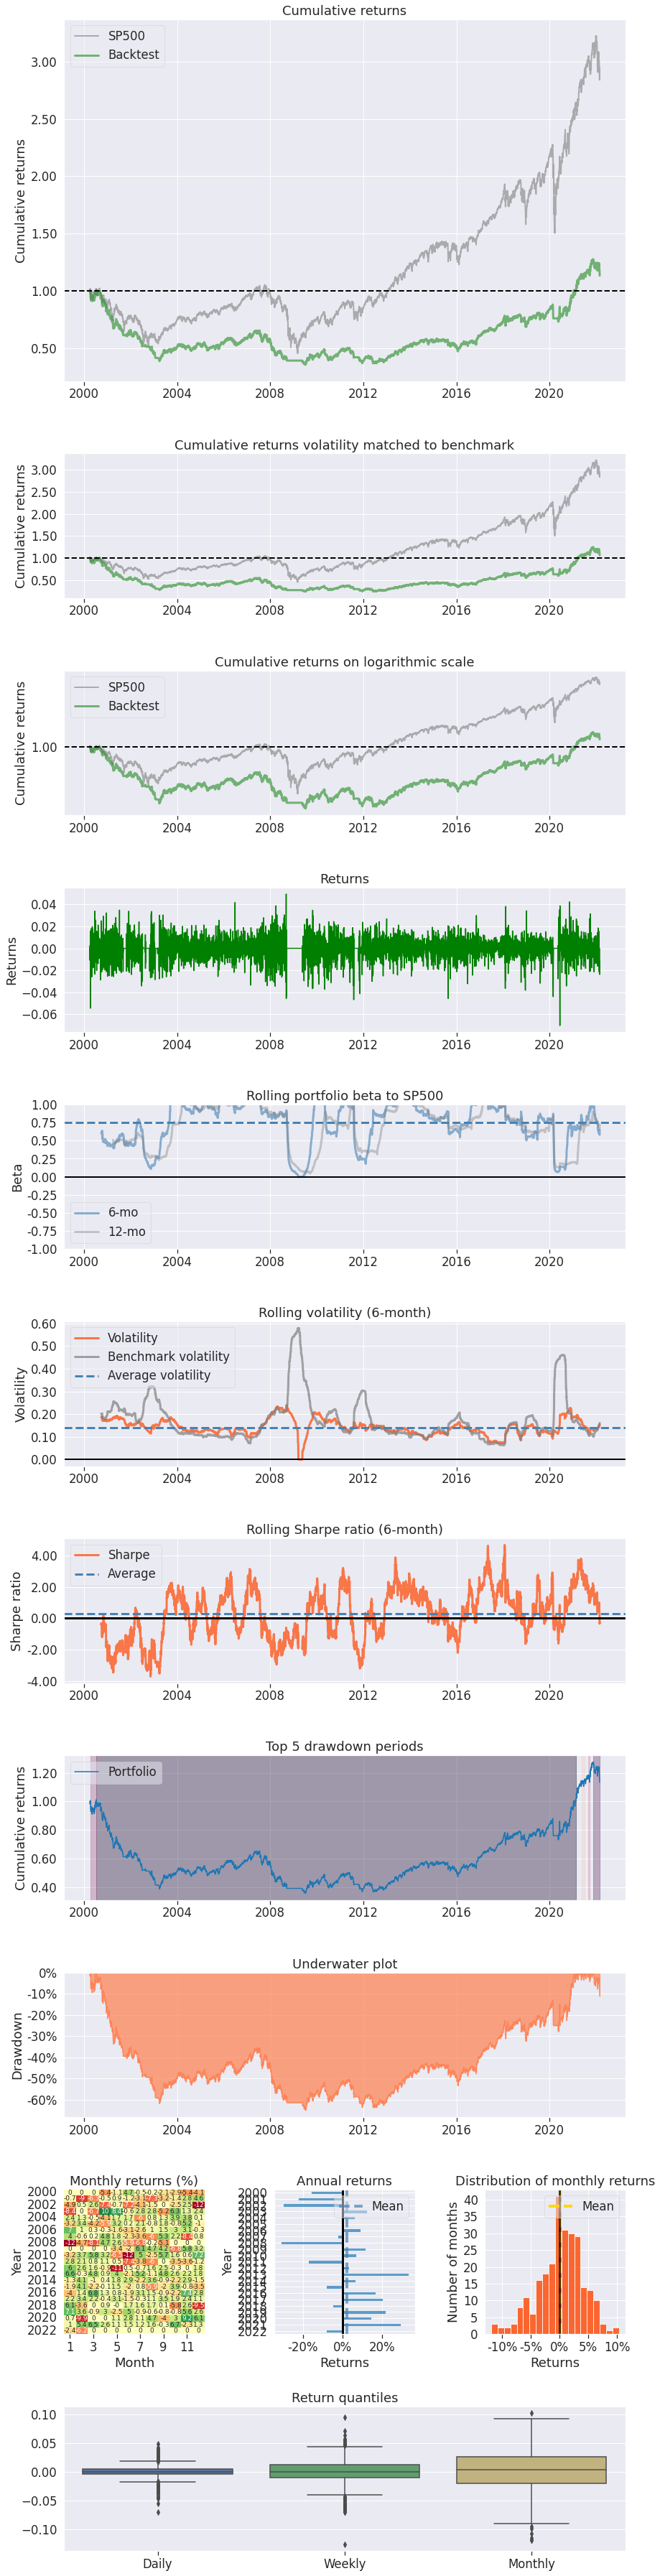

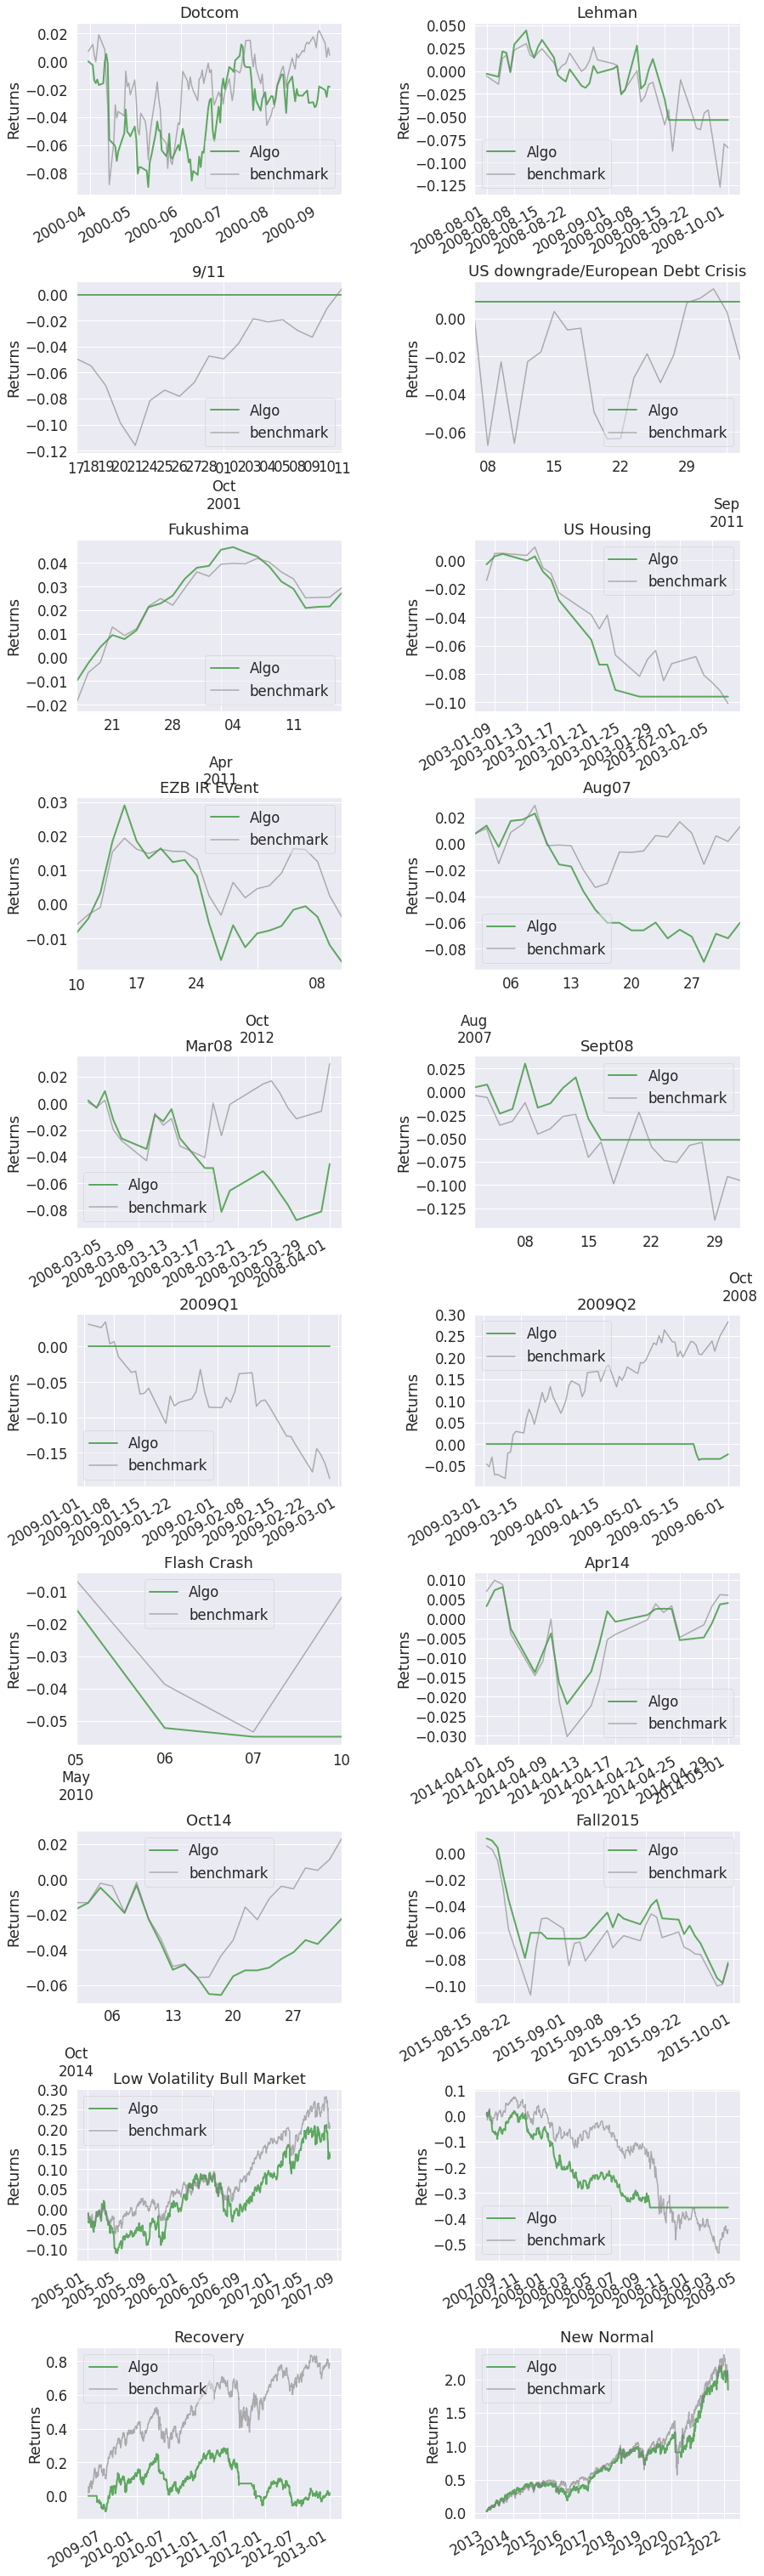

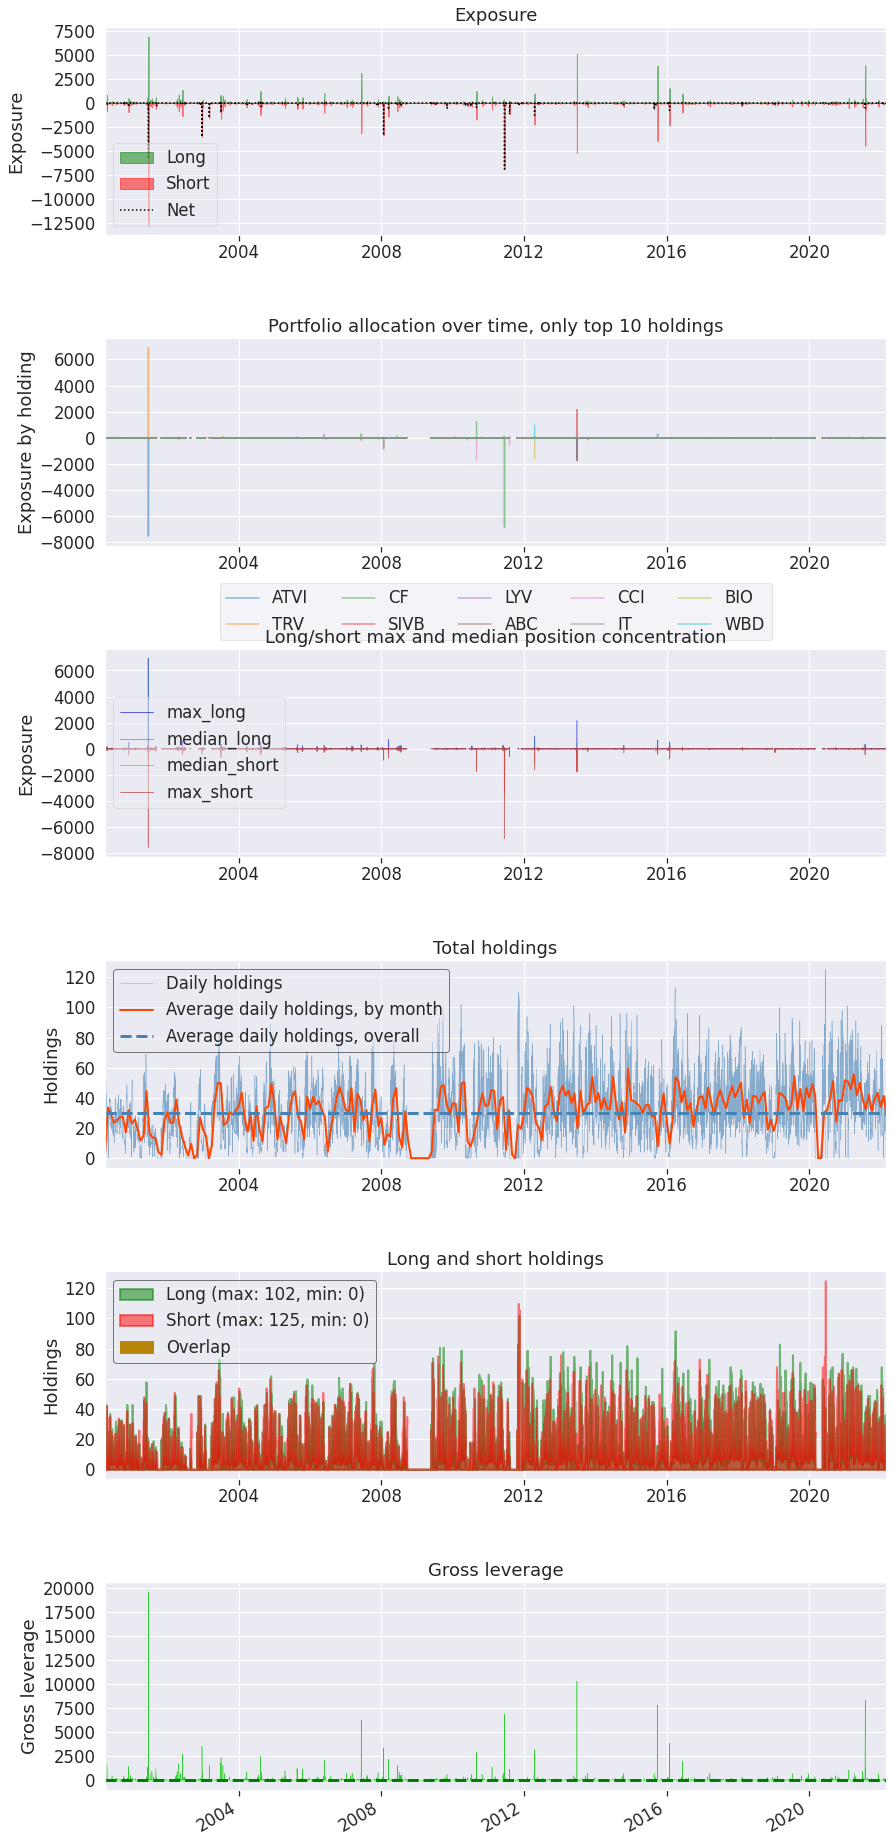

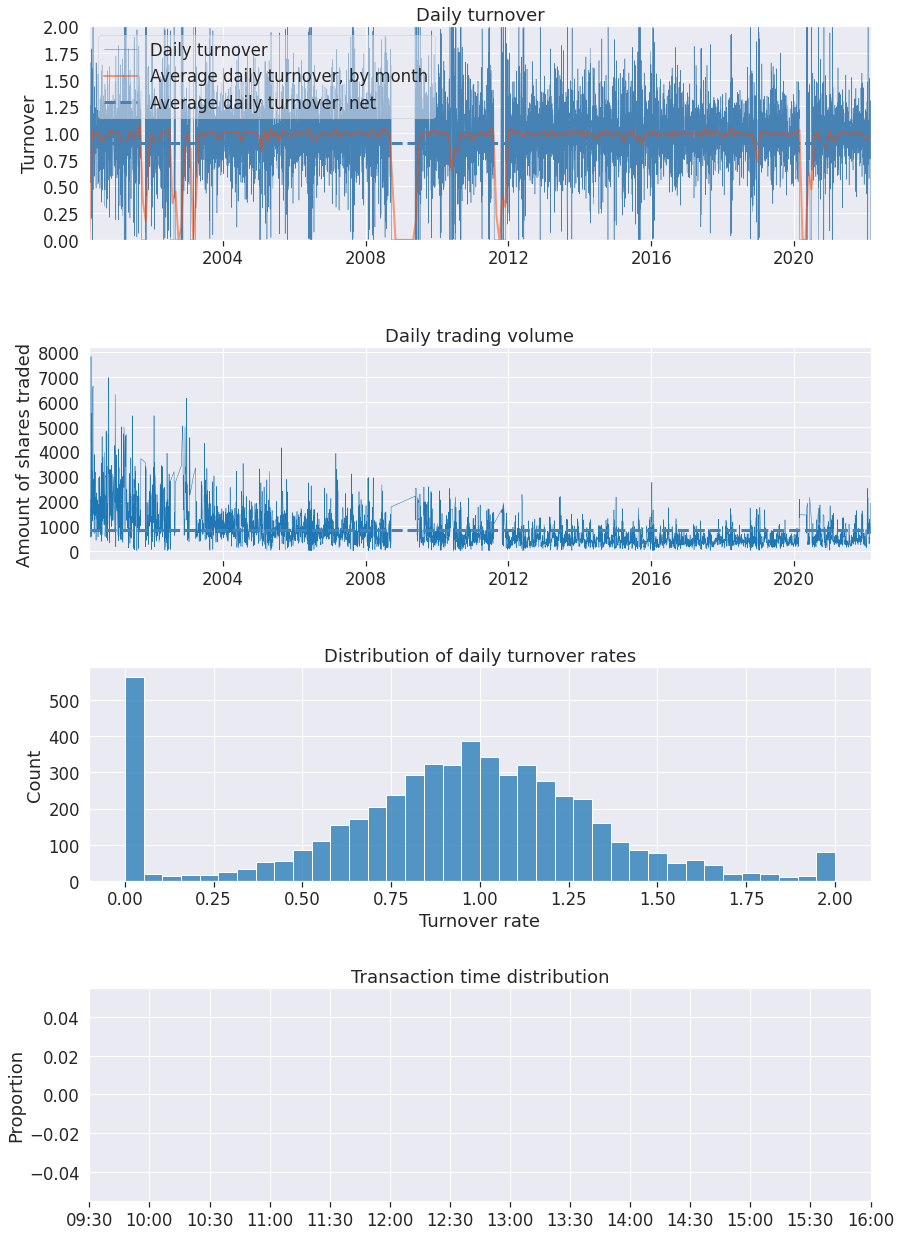

In [16]:
'''
Refer to this get the available functions for plotting: 
— https://mw572.github.io/All%20Weather%20V1/All%20Weather%20V1%20Full%20Analysis.html
— https://www.quantrocket.com/codeload/quant-finance-lectures/quant_finance_lectures/Lecture33-Portfolio-Analysis-with-pyfolio.ipynb.html
'''

%matplotlib inline 

# The datetime index from the benchmark must contain the extact dates. 
idx_benchmark = df_benchmark.index.difference(returns.index) 
idx_benchmark = df_benchmark.index.difference(idx_benchmark) 

pf.create_full_tear_sheet(
	returns,
	transactions=transactions,
	positions=positions,
	benchmark_rets=df_benchmark[idx_benchmark].dropna()
)